# Search: Solving a Maze Using a Goal-based Agent

Student Name: Đinh Công Thuận
I have used the following AI tools: ChatGPT

I understand that my submission needs to be my own work: Thuan

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [ ]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [ ]:
!cp /content/drive/MyDrive/ai_nangcao/maze_helper.py .


In [ ]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

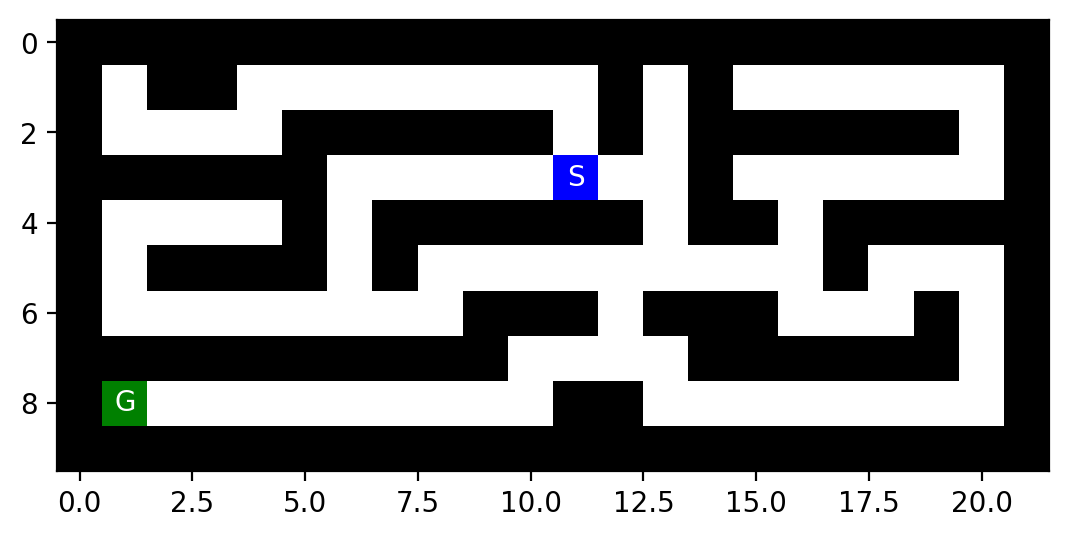

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [ ]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [ ]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [ ]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [ ]:
1. Trạng thái ban đầu (Initial State)

Trạng thái ban đầu là vị trí xuất phát của tác tử trong mê cung, ký hiệu là S:
s0 = (rS, cS)

Trong đó rS, cS là hàng và cột của ô bắt đầu.

2. Tập hành động (Actions)

Từ mỗi ô trống, tác tử có thể di chuyển theo 4 hướng:

A = {Lên, Xuống, Trái, Phải}

Một hành động hợp lệ nếu:

Không đi ra ngoài biên mê cung.

Không đi vào ô tường (ký hiệu X).

3. Mô hình chuyển trạng thái (Transition Model)

Mô tả kết quả của việc thực hiện một hành động a tại trạng thái s:

Result(s, a) = s' = (r', c')

Nếu hành động dẫn đến ô tường hoặc vượt biên, trạng thái mới không hợp lệ.

4. Trạng thái đích (Goal State)

Trạng thái đích là ô có ký hiệu G:

s_goal = (rG, cG)

Bài toán đạt mục tiêu khi:

GoalTest(s) = (s == s_goal)

5. Chi phí đường đi (Path Cost)

Mỗi bước di chuyển giữa hai ô liền kề có chi phí bằng 1:

Cost(s, a, s') = 1

Tổng chi phí đường đi là số bước di chuyển từ S đến G.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [ ]:
n: Đếm tổng số ô trống trong mê cung.

d: Dùng BFS để tìm đường đi ngắn nhất từ S đến G.

m: Với tìm kiếm đồ thị, lấy n−1 làm cận trên.

b: Đếm số hướng đi hợp lệ trung bình (2–4 tùy cấu trúc mê cung).

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [ ]:
from collections import deque
import numpy as np
import heapq  # Import heapq for priority queue

ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def is_valid_move(maze, pos):
    """Kiểm tra xem ô có hợp lệ để di chuyển không."""
    r, c = pos
    return 0 <= r < maze.shape[0] and 0 <= c < maze.shape[1] and maze[r, c] != 'X'


def find_position(maze, symbol):
    """Tìm tọa độ của ký tự (S hoặc G) trong mê cung."""
    locations = np.where(maze == symbol)
    if len(locations[0]) > 0:
        return (locations[0][0], locations[1][0])
    return None


def get_neighbors(pos, maze):
    """Trả về các ô lân cận hợp lệ."""
    neighbors = []
    for action in ACTIONS:
        new_pos = (pos[0] + action[0], pos[1] + action[1])
        if is_valid_move(maze, new_pos):
            neighbors.append(new_pos)
    return neighbors

class Node:
    def __init__(self, pos, parent=None, action=None, cost=0, heuristic=0):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.heuristic = heuristic # h(n) for GBFS and A*
        self.f = self.cost + self.heuristic # f(n) for A*

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}; heuristic = {self.heuristic}"

    # Add comparison methods for heapq
    def __lt__(self, other):
        # For GBFS, compare by heuristic. For A*, compare by f value.
        # This method is primarily used by heapq.
        return self.f < other.f

    def __eq__(self, other):
        return self.pos == other.pos

    def __hash__(self):
        return hash(self.pos)


    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)


def bfs_search(maze):
    start = find_position(maze, 'S')
    goal = find_position(maze, 'G')

    if start is None or goal is None:
        return None, 0, 0, 0

    root = Node(start, None, None, 0)
    frontier = deque([root])
    reached = {root.pos}

    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0

    while frontier:
        node = frontier.popleft()
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)

        if node.pos == goal:
            return node, nodes_expanded, max_depth, max_frontier_size

        for action in ACTIONS:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if is_valid_move(maze, new_pos) and new_pos not in reached:
                reached.add(new_pos)
                child = Node(new_pos, node, action, node.cost + 1)
                frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))

    return None, nodes_expanded, max_depth, max_frontier_size




In [ ]:
def dfs_search_unlimited(maze):
    start = find_position(maze, 'S')
    goal = find_position(maze, 'G')
    if start is None or goal is None:
        return None, 0, 0, 0

    root = Node(start)
    frontier = [root]
    visited = set()
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0

    while frontier:
        node = frontier.pop()
        if node.pos in visited:
            continue
        visited.add(node.pos)
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)

        if node.pos == goal:
            return node, nodes_expanded, max_depth, max_frontier_size

        # Lặp qua các hành động (có thể đảo thứ tự)
        for action in ACTIONS[::-1]:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if is_valid_move(maze, new_pos):
                child = Node(new_pos, node, action, node.cost + 1)
                frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))

    return None, nodes_expanded, max_depth, max_frontier_size


How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [ ]:
readth-First Search (BFS):

BFS thường sử dụng tập trạng thái đã thăm (reached/visited) để lưu lại các nút đã được khám phá.

Điều này giúp tránh quay lại cùng một trạng thái và ngăn chặn vòng lặp vô hạn.

Nếu không dùng tập này, BFS có thể mở rộng lại các trạng thái đã thăm nhiều lần, dẫn đến tăng trưởng số lượng frontier theo cấp số nhân và có thể rơi vào vòng lặp vô hạn trong mê cung có chu trình.

Depth-First Search (DFS):

DFS nếu không dùng tập reached cũng có nguy cơ quay lại cùng trạng thái nhiều lần, gây vòng lặp vô hạn hoặc đệ quy không dừng.

Để hạn chế, DFS thường kiểm tra vòng lặp trên đường đi hiện tại (current path/recursion stack).

Việc này ngăn DFS đi theo chu trình lặp nhưng vẫn có thể tạo ra đường đi thừa nếu trạng thái có thể đạt từ nhiều nhánh khác nhau.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [ ]:
BFS hoàn thiện và luôn tìm đường đi ngắn nhất trong mê cung không trọng số, nên tối ưu. DFS không dùng tập reached cần cycle checking để tránh lặp vô hạn, nhưng không đảm bảo tối ưu.

Độ phức tạp của BFS là thời gian O(b^d) và bộ nhớ O(b^d), vì frontier lưu tất cả các nút cùng mức. DFS có thời gian O(b^m) nhưng bộ nhớ chỉ O(m), vì chỉ lưu các nút trên đường đi hiện tại.

Như vậy, DFS tiết kiệm bộ nhớ hơn BFS nhưng không đảm bảo tìm đường ngắn nhất. Lựa chọn thuật toán phụ thuộc vào yêu cầu tối ưu và tài nguyên bộ nhớ.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [ ]:
def manhattan(pos1, pos2):
    """Tính khoảng cách Manhattan giữa hai tọa độ (row, col)."""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

In [ ]:
import heapq

def gbfs_search(maze):
    start = find_position(maze, 'S')
    goal = find_position(maze, 'G')

    start_node = Node(start, None, 0, manhattan(start, goal))
    frontier = []
    heapq.heappush(frontier, (start_node.heuristic, start_node))  # (priority, Node)
    explored = set()
    max_frontier = 1

    while frontier:
        _, node = heapq.heappop(frontier)

        if node.pos == goal:
            return node, len(explored), node.cost, max_frontier

        explored.add(node.pos)

        for nbr in get_neighbors(node.pos, maze):
            # tránh thêm trùng lặp vào frontier
            if nbr not in explored and all(nbr != n.pos for _, n in frontier):
                child = Node(pos=nbr, parent=node, action=None, cost=node.cost + 1, heuristic=manhattan(nbr, goal))
                heapq.heappush(frontier, (child.heuristic, child))

        max_frontier = max(max_frontier, len(frontier))

    return None, len(explored), 0, max_frontier


In [ ]:
import heapq

def astar_search(maze):
    start = find_position(maze, 'S')
    goal = find_position(maze, 'G')

    start_node = Node(start, None, 0, manhattan(start, goal))
    frontier = []
    heapq.heappush(frontier, (start_node.f, start_node))
    explored = set()
    max_frontier = 1

    while frontier:
        _, node = heapq.heappop(frontier)

        if node.pos == goal:
            return node, len(explored), node.cost, max_frontier

        explored.add(node.pos)

        for nbr in get_neighbors(node.pos, maze):
            if nbr not in explored and all(nbr != n.pos for _, n in frontier):
                g = node.cost + 1
                h = manhattan(nbr, goal)
                child = Node(pos=nbr, parent=node, action=None, cost=node.cost + 1, heuristic=manhattan(nbr, goal))
                heapq.heappush(frontier, (child.f, child))

        max_frontier = max(max_frontier, len(frontier))

    return None, len(explored), 0, max_frontier


Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
Greedy Best-First Search (GBFS):

Hoàn thiện: Không hoàn thiện trong mê cung có vòng lặp vô hạn, nhưng với cycle checking thì thuật toán sẽ kết thúc.

Tối ưu: Không tối ưu, vì GBFS chỉ dựa trên heuristic h(n) và có thể chọn đường đi dài hơn đường đi ngắn nhất.

Độ phức tạp:

Thời gian: O(b^m) trong trường hợp xấu nhất, với m là độ sâu tối đa.

Bộ nhớ: O(b^m), vì phải lưu frontier dưới dạng priority queue.

A Search:*

Hoàn thiện: Có, nếu heuristic admissible (không vượt quá chi phí thực tế).

Tối ưu: Có, A* luôn tìm đường đi ngắn nhất trong mê cung không trọng số nếu heuristic admissible.

Độ phức tạp:

Thời gian: O(b^d), với d là độ sâu lời giải tối ưu.

Bộ nhớ: O(b^d), frontier lưu tất cả nút mở rộng theo giá trị f(n) = g(n) + h(n).

So sánh:

GBFS nhanh nhưng không đảm bảo tối ưu và không hoàn thiện nếu không có cycle checking.

A* cân bằng giữa thời gian và tối ưu, nhưng tốn bộ nhớ hơn DFS do frontier có thể rất lớn.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [ ]:
import pandas as pd

# Danh sách maze và thuật toán
mazes = ["small", "medium", "large", "wall", "loops", "empty", "empty2", "open"]
algorithms = [bfs_search, dfs_search, gbfs_search, astar_search]

results = []

for maze_name in mazes:
    # load_maze là hàm bạn tự định nghĩa, trả về np.array
    maze = load_maze(maze_name)
    if maze is None:
        continue

    for algo in algorithms:
        try:
            node, nodes_expanded, max_depth, max_frontier = algo(maze)
            if node:
                path_cost = node.cost
            else:
                path_cost = "N/A"
                nodes_expanded = max_depth = max_frontier = "N/A"
        except Exception as e:
            path_cost = nodes_expanded = max_depth = max_frontier = "Error"

        results.append({
            "Maze": maze_name,
            "Algorithm": algo.__name__,
            "Path Cost": path_cost,
            "Nodes Expanded": nodes_expanded,
            "Max Tree Depth": max_depth,
            "Max Frontier Size": max_frontier
        })






In [ ]:
df = pd.DataFrame(results)
df

,Maze,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size
0,small,bfs_search,19,92,19,8
1,small,dfs_search,29,54,29,21
2,small,gbfs_search,44,39,44,5
3,small,astar_search,34,52,34,8
4,medium,bfs_search,68,270,68,8
5,medium,dfs_search,164,259,164,105
6,medium,gbfs_search,122,78,122,4
7,medium,astar_search,116,221,116,8
8,large,bfs_search,210,621,210,8
9,large,dfs_search,210,470,210,152


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

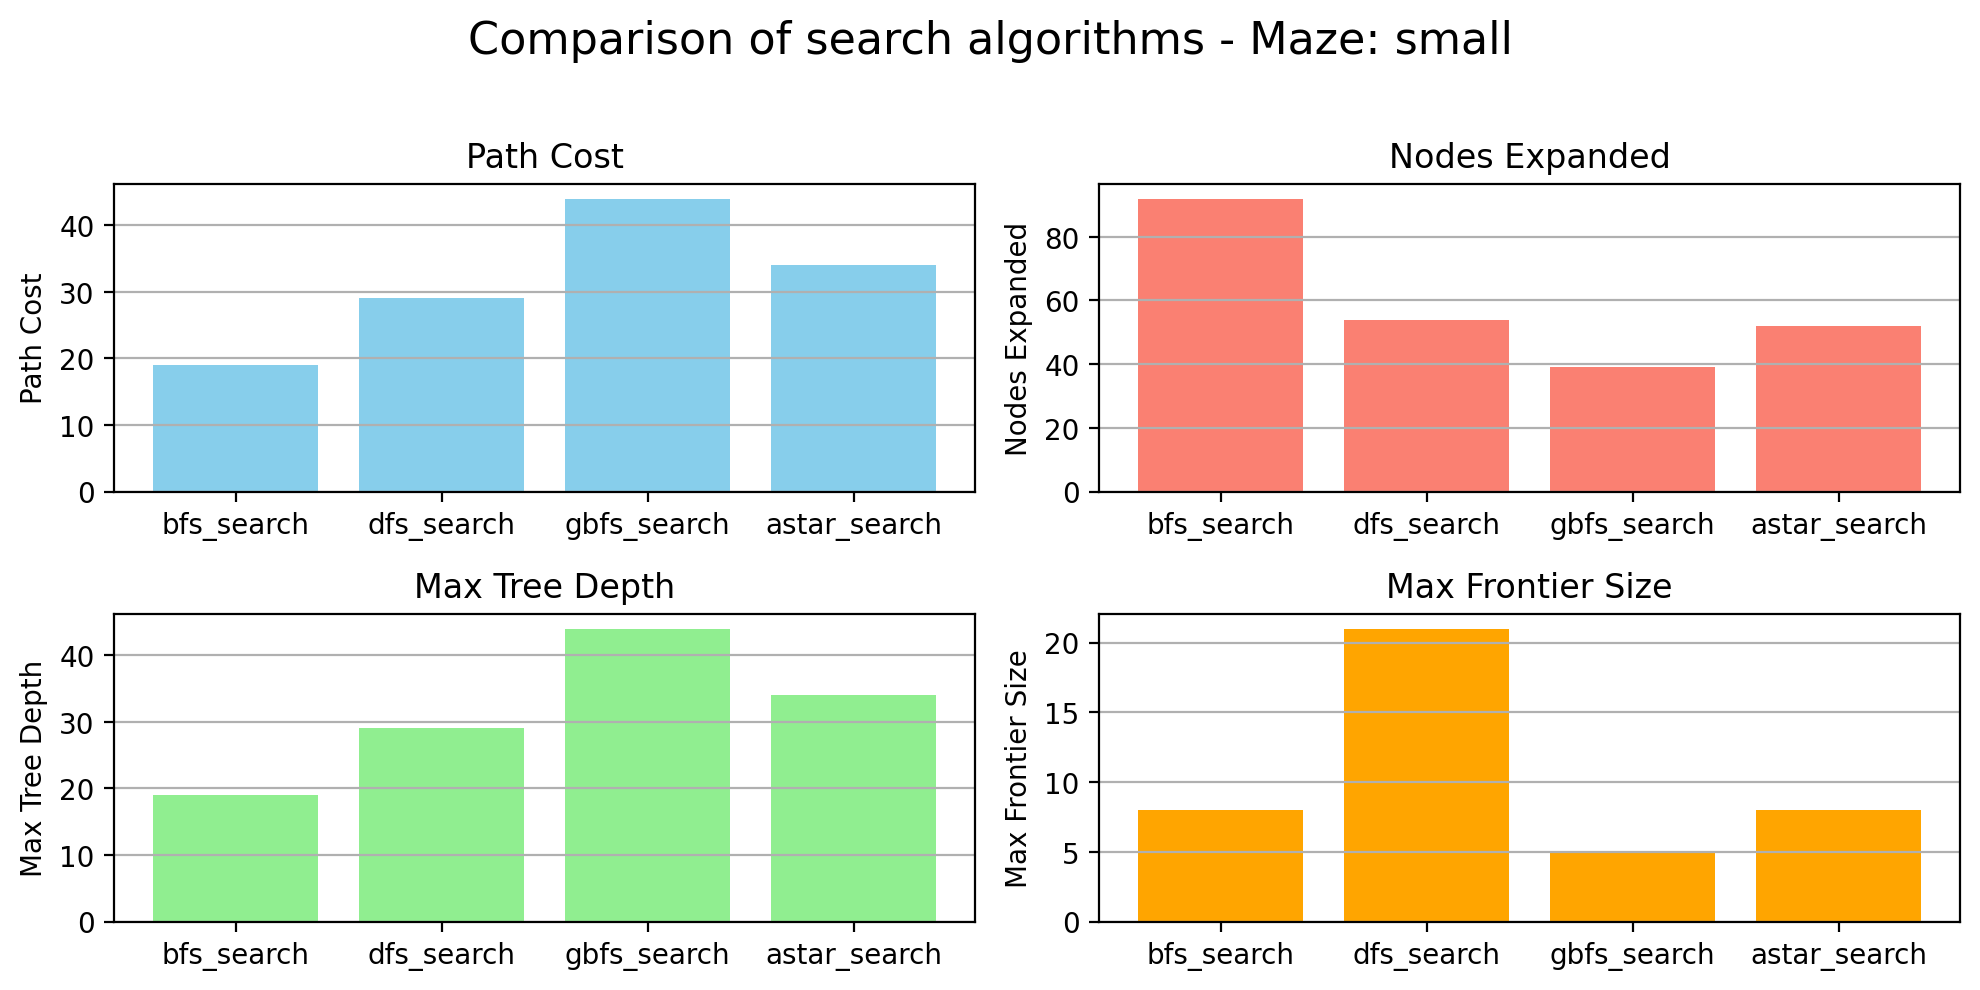

      Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Frontier Size
0    bfs_search         19              92              19                  8
1    dfs_search         29              54              29                 21
2   gbfs_search         44              39              44                  5
3  astar_search         34              52              34                  8


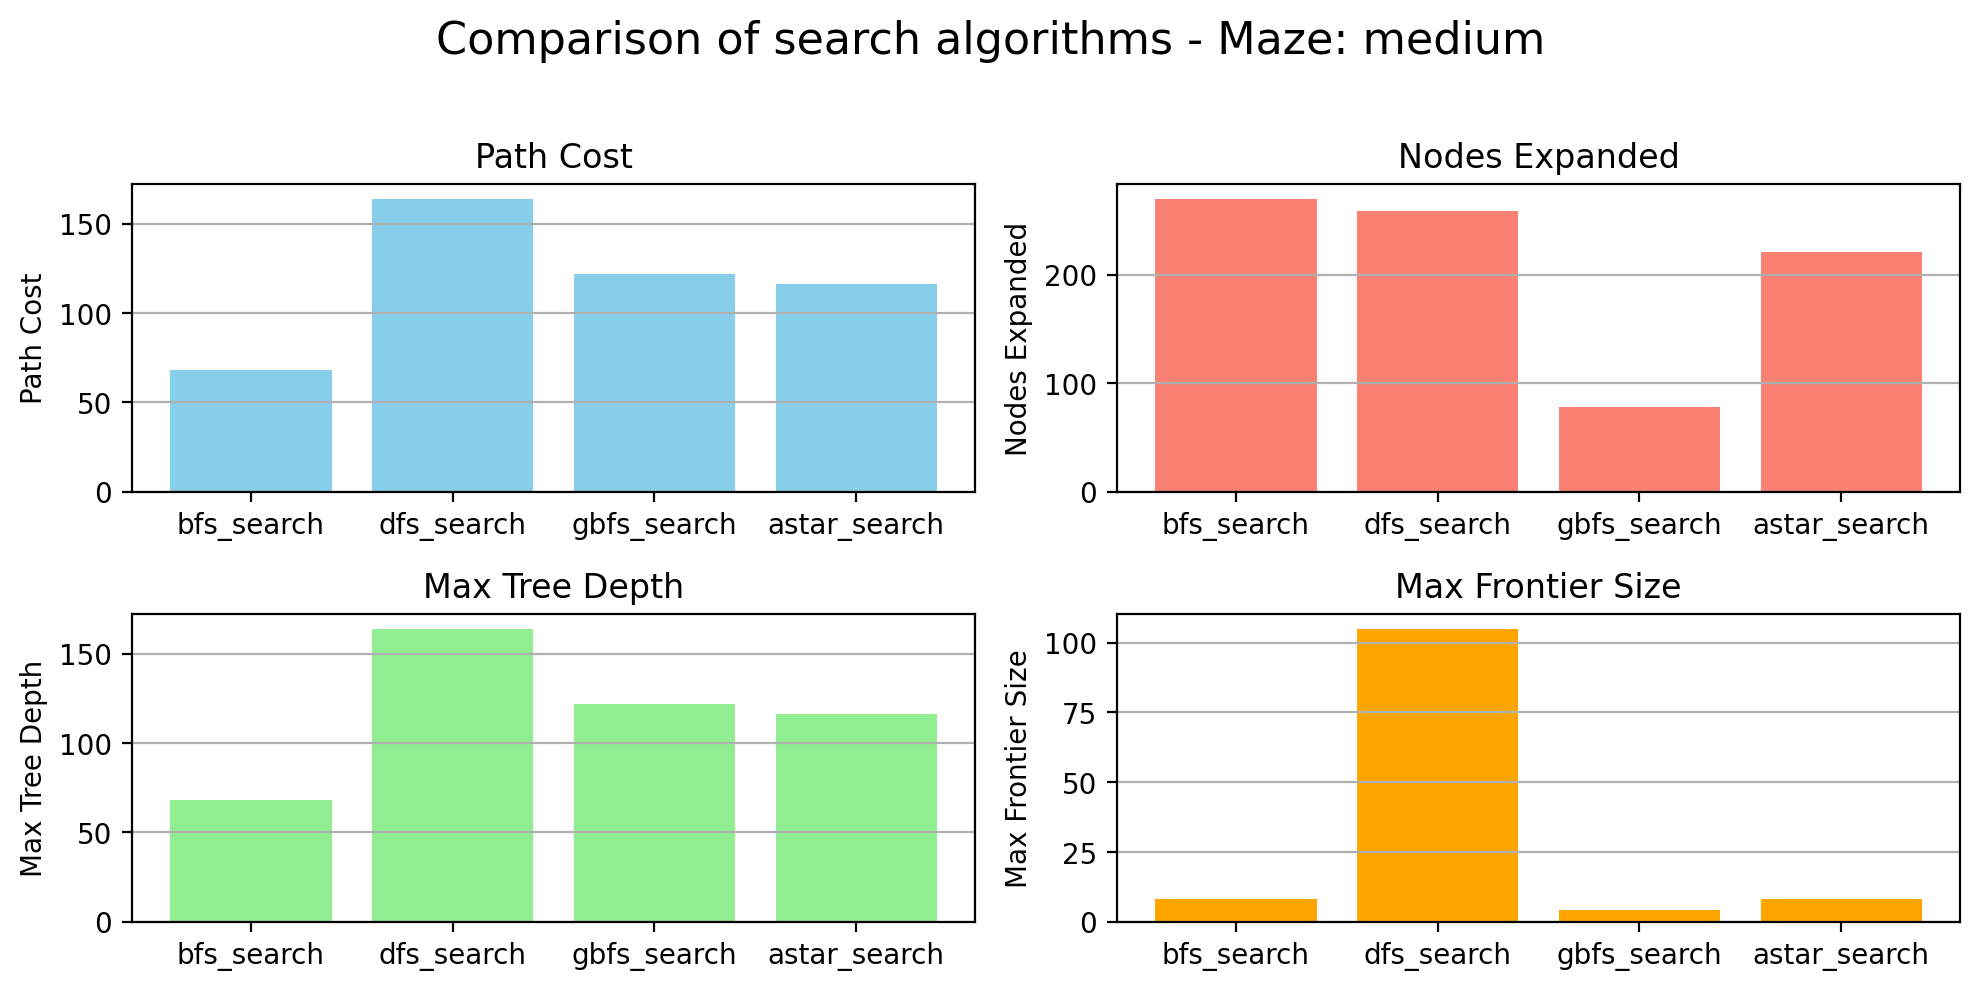

      Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Frontier Size
4    bfs_search         68             270              68                  8
5    dfs_search        164             259             164                105
6   gbfs_search        122              78             122                  4
7  astar_search        116             221             116                  8


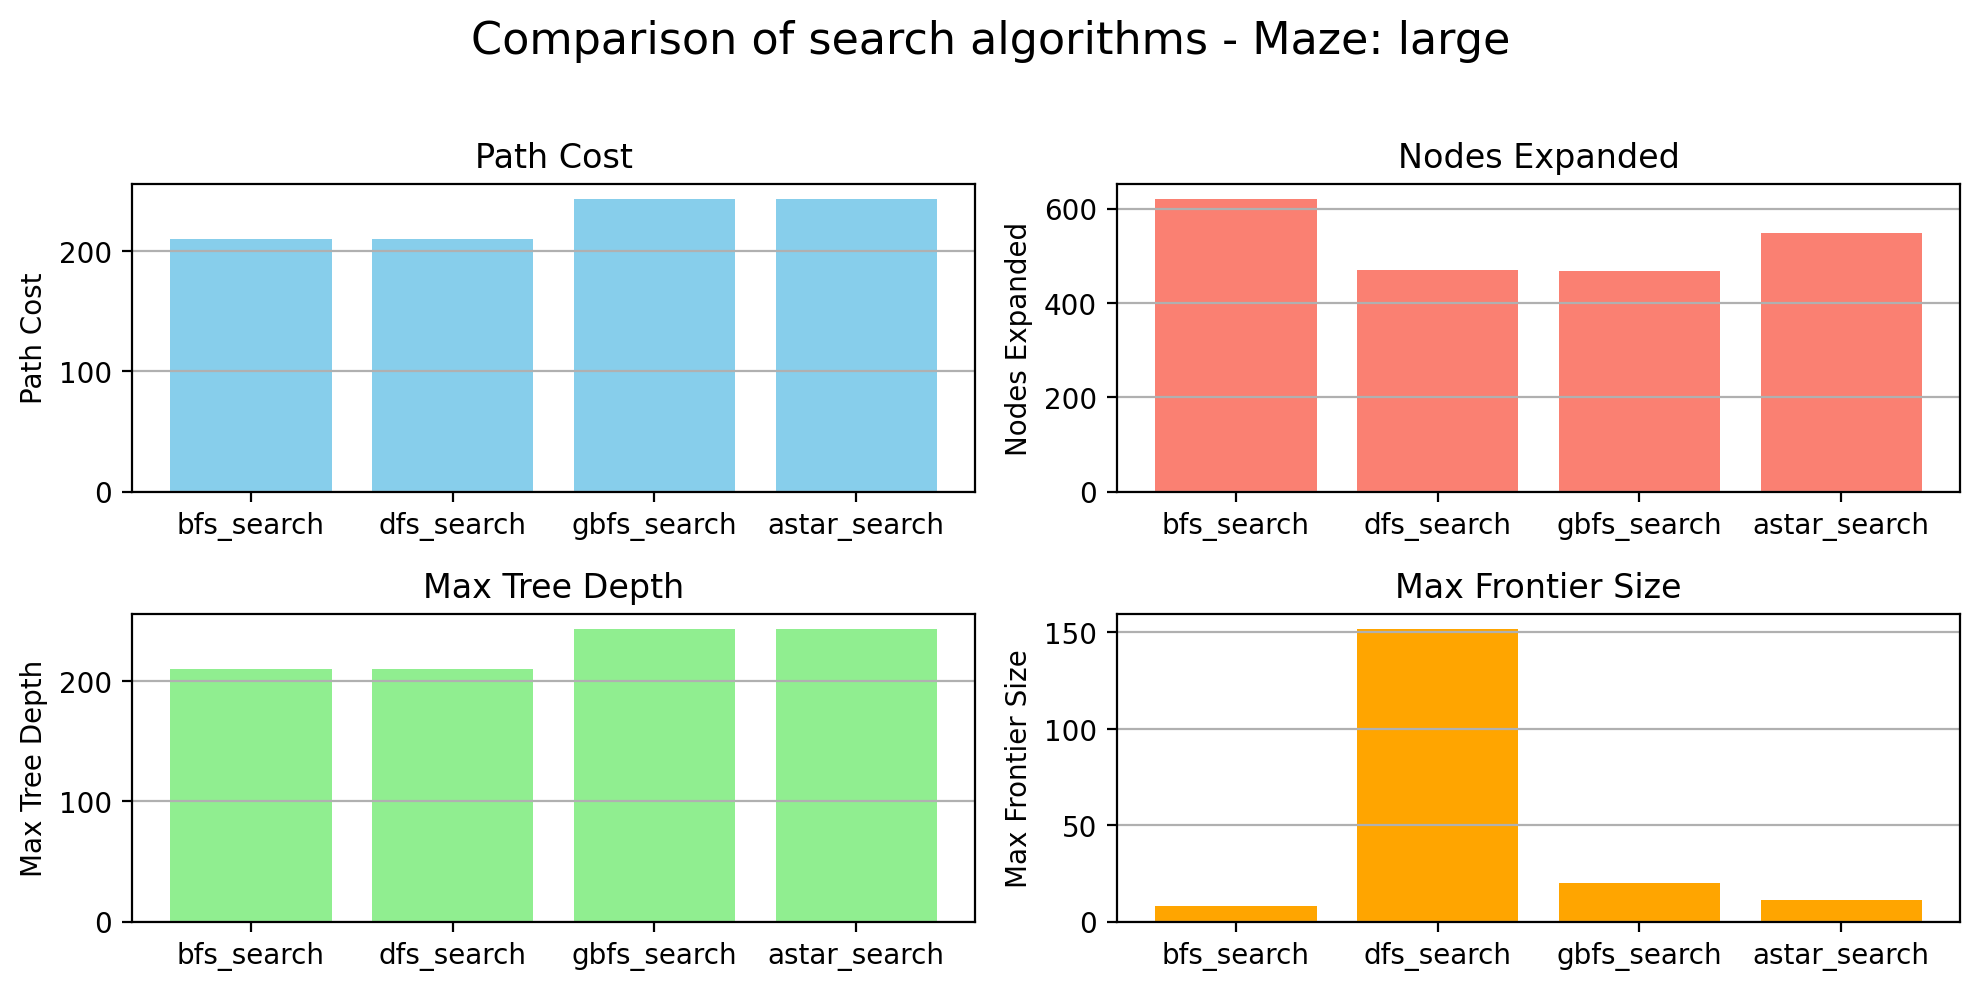

       Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Frontier Size
8     bfs_search        210             621             210                  8
9     dfs_search        210             470             210                152
10   gbfs_search        244             467             244                 20
11  astar_search        244             549             244                 11


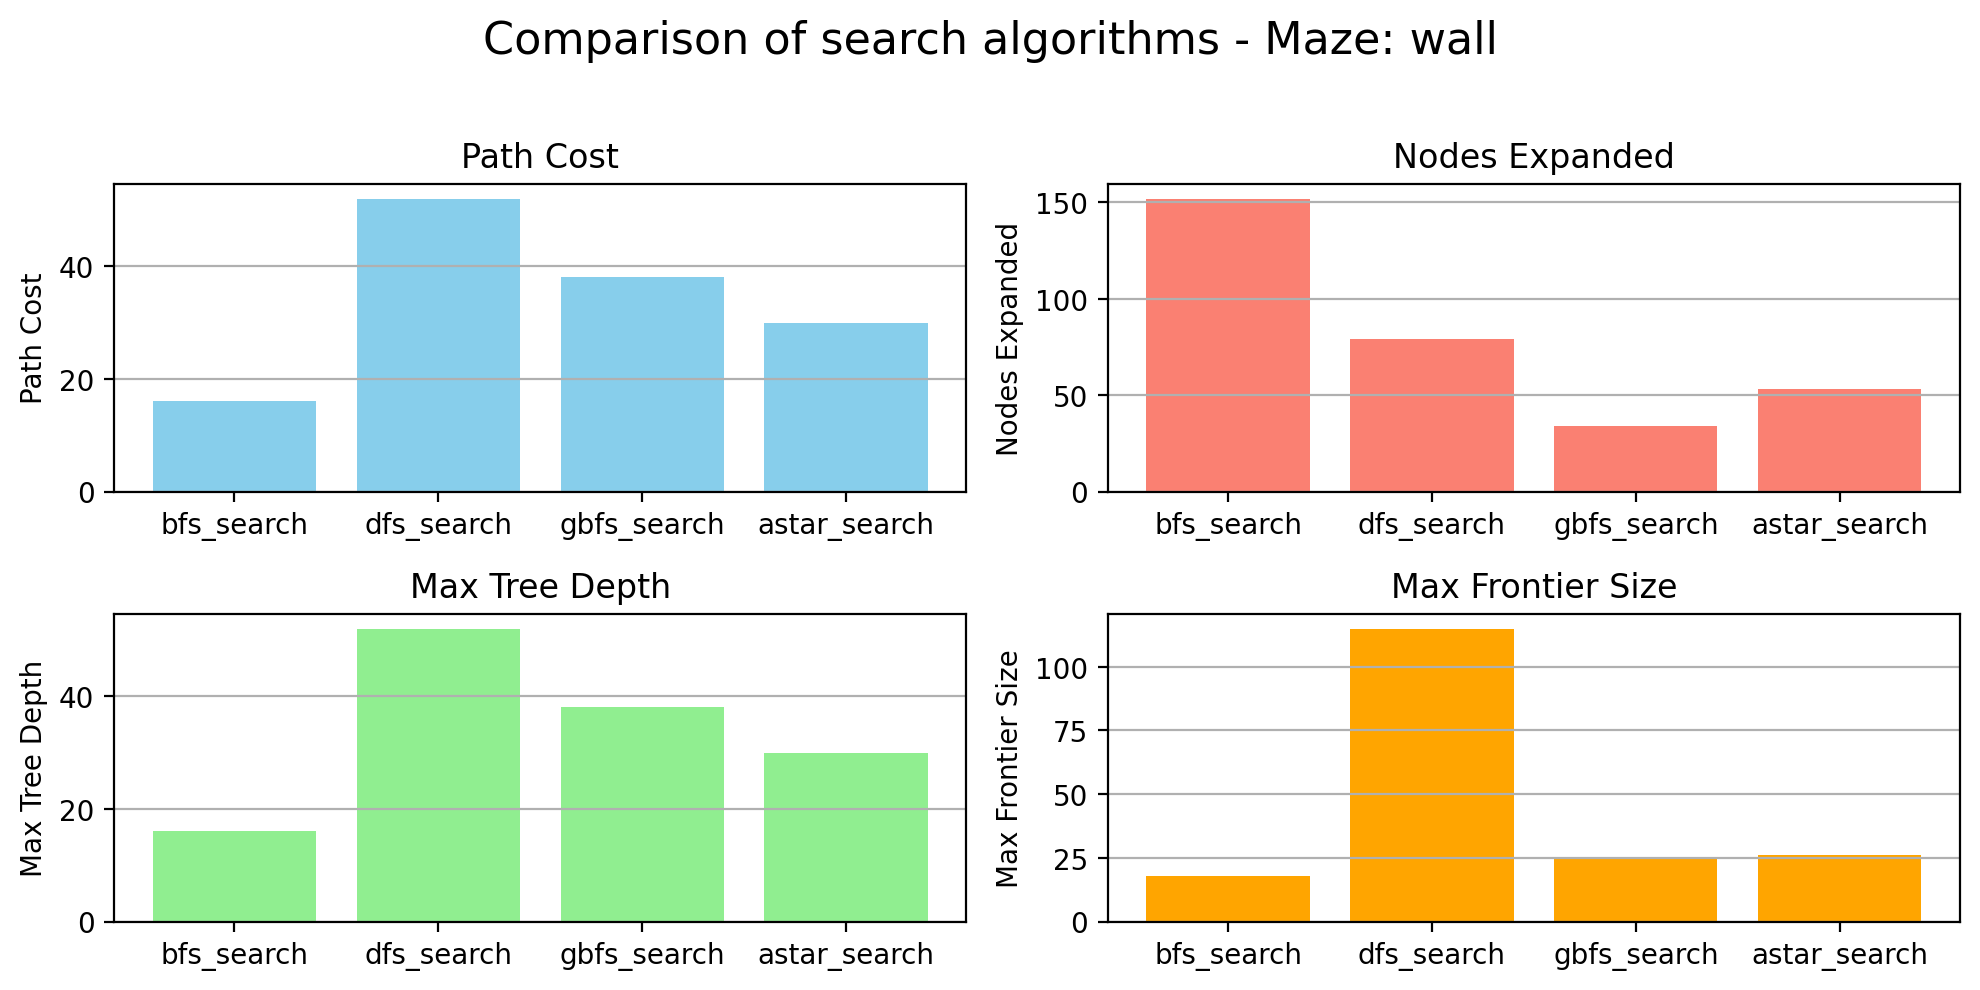

       Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Frontier Size
12    bfs_search         16             152              16                 18
13    dfs_search         52              79              52                115
14   gbfs_search         38              34              38                 25
15  astar_search         30              53              30                 26


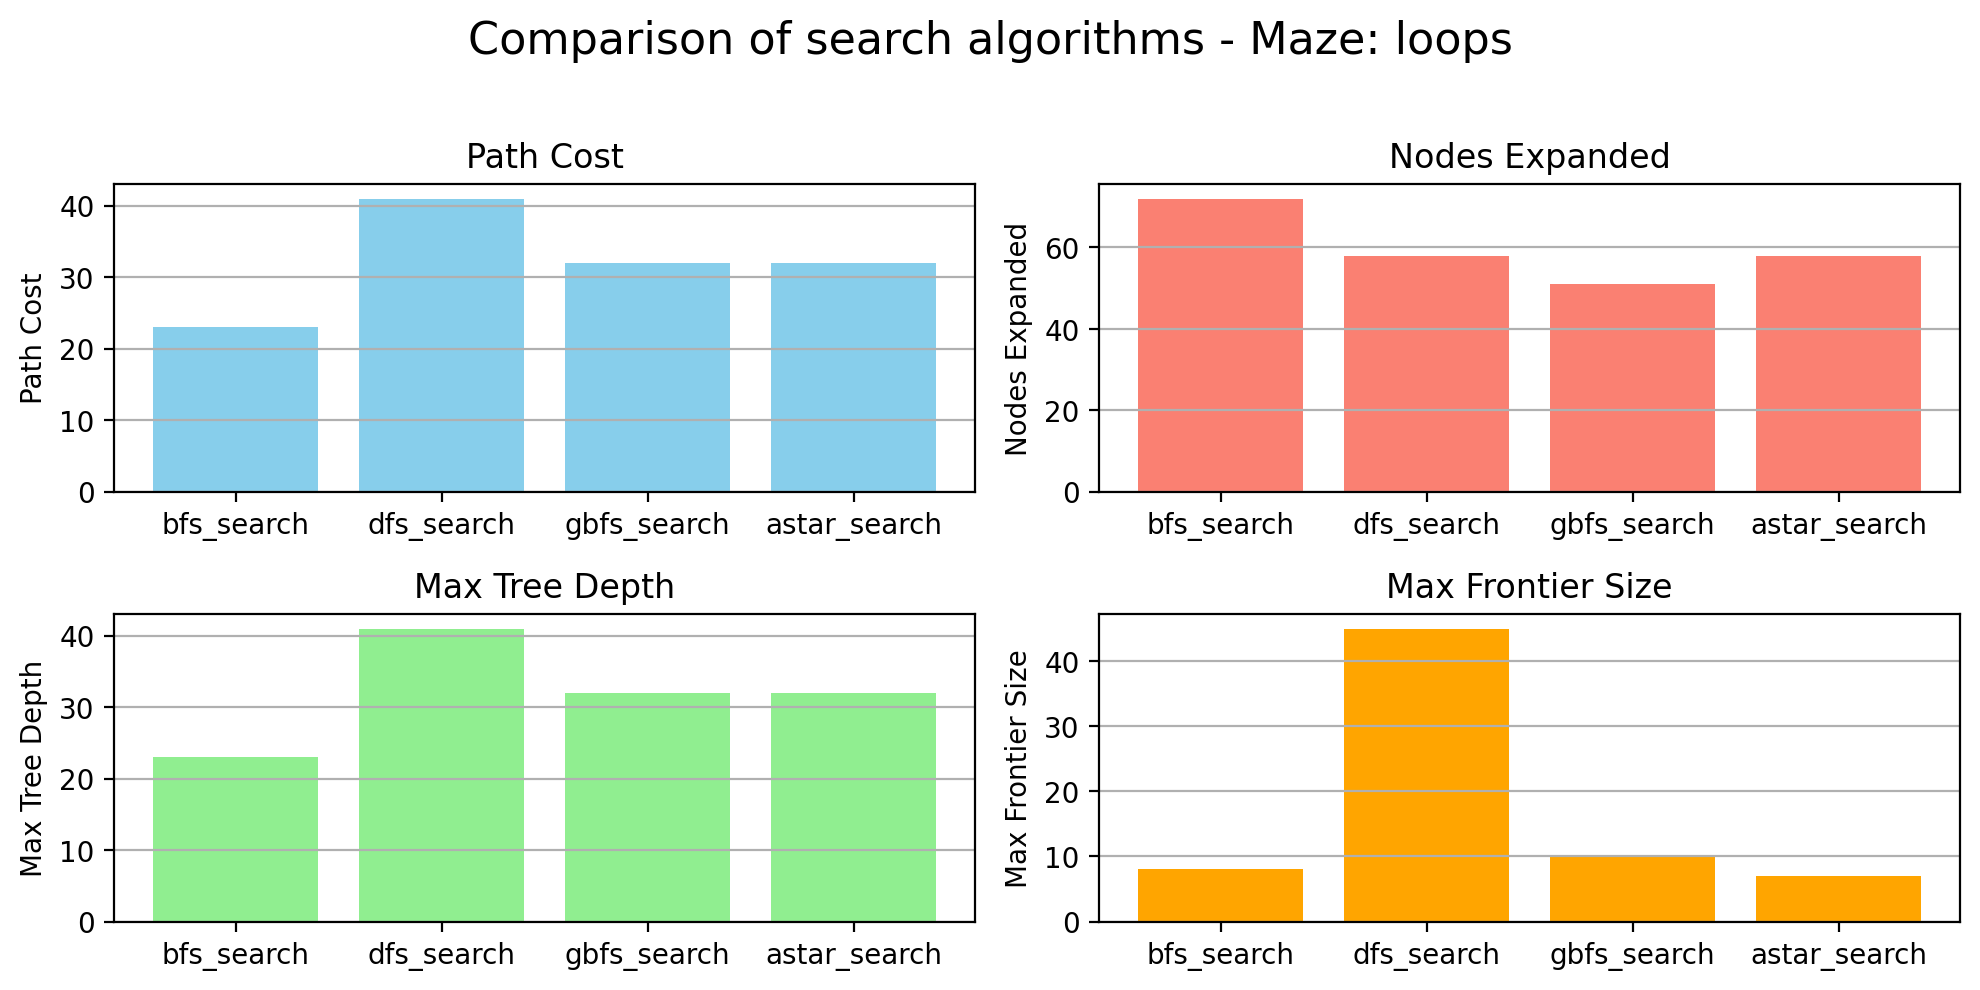

       Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Frontier Size
16    bfs_search         23              72              23                  8
17    dfs_search         41              58              41                 45
18   gbfs_search         32              51              32                 10
19  astar_search         32              58              32                  7


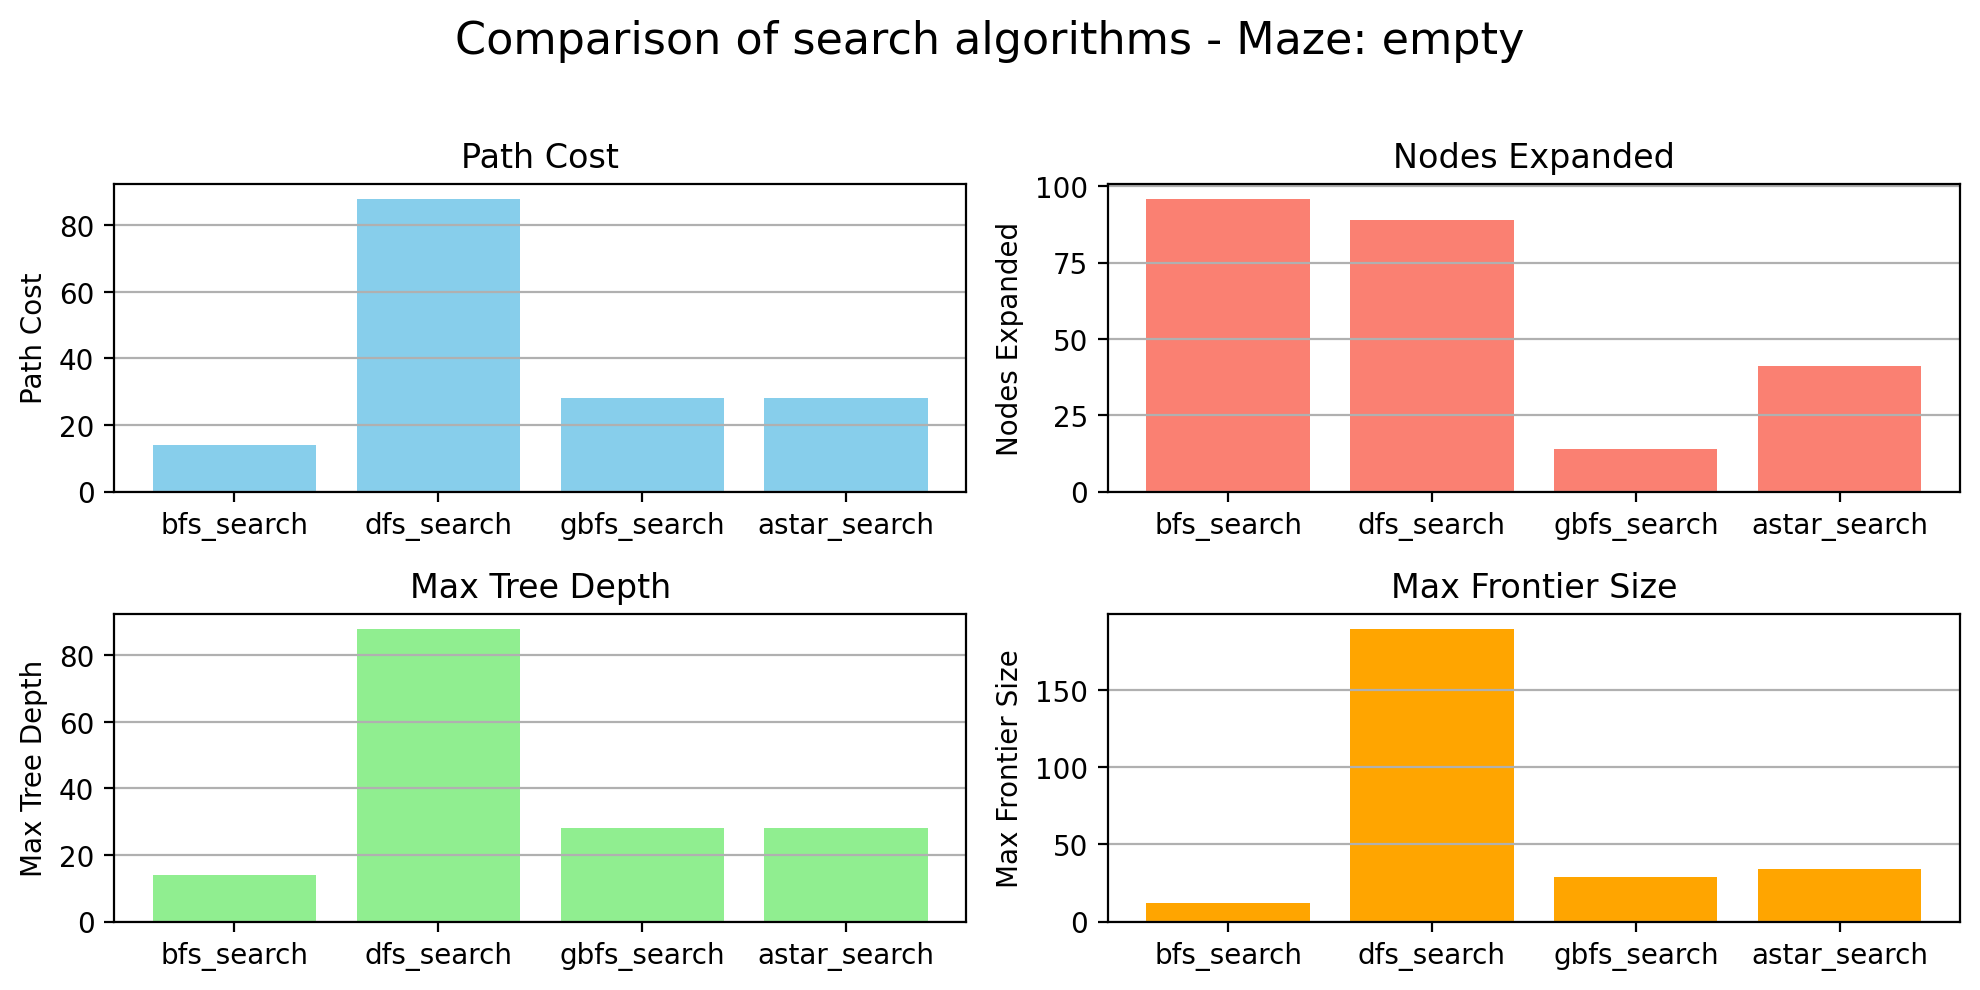

       Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Frontier Size
20    bfs_search         14              96              14                 12
21    dfs_search         88              89              88                190
22   gbfs_search         28              14              28                 29
23  astar_search         28              41              28                 34


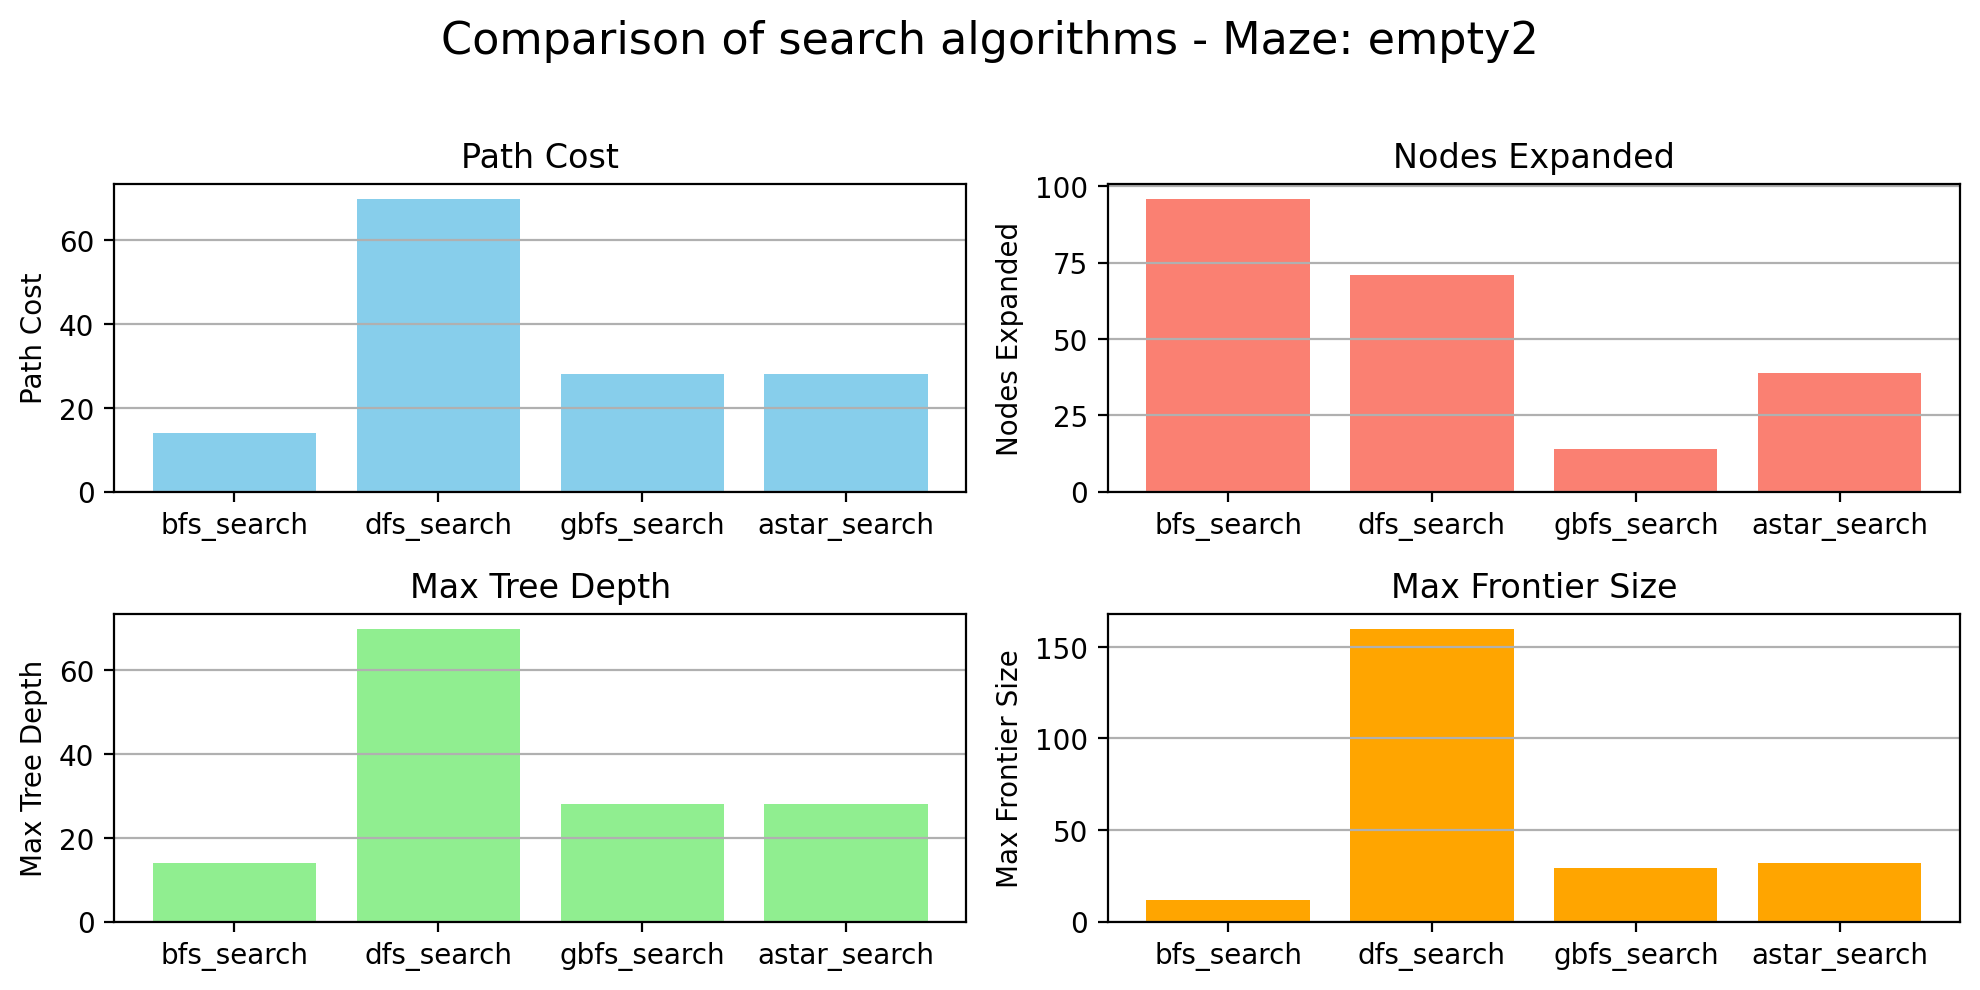

       Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Frontier Size
24    bfs_search         14              96              14                 12
25    dfs_search         70              71              70                160
26   gbfs_search         28              14              28                 29
27  astar_search         28              39              28                 32


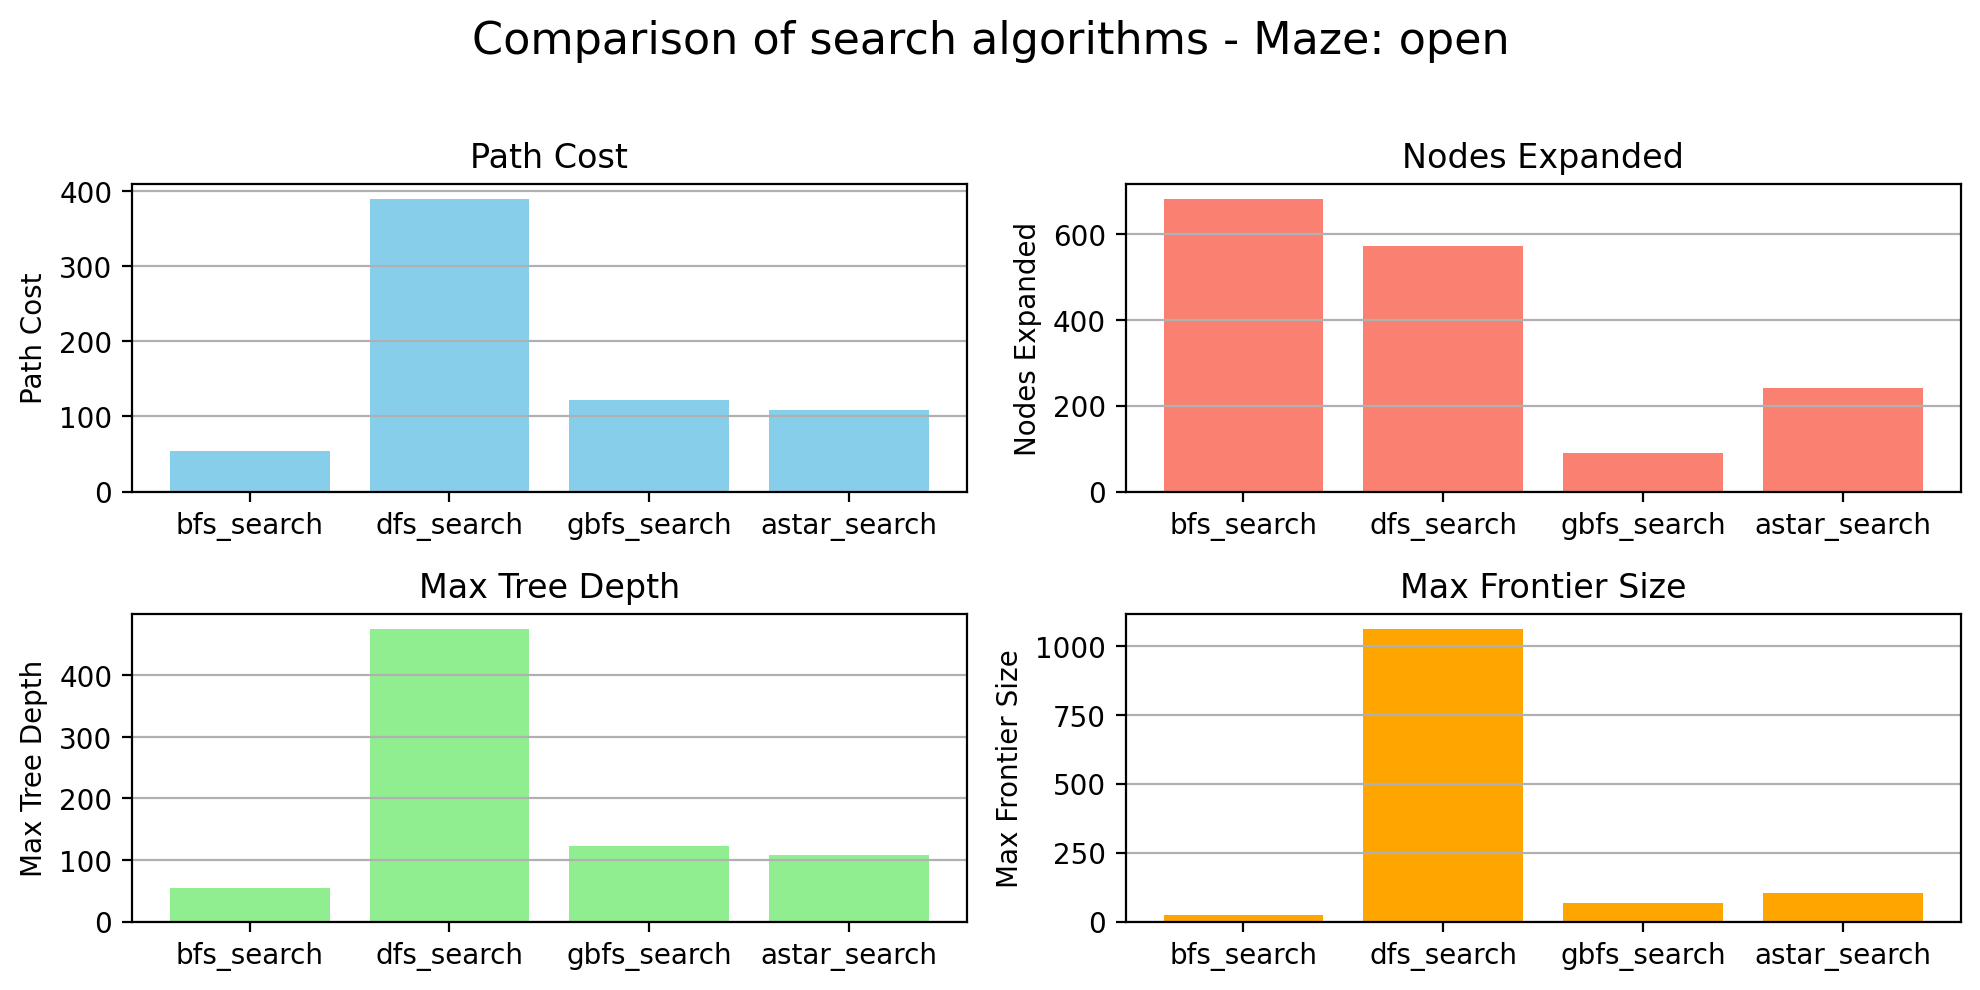

       Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Frontier Size
28    bfs_search         54             683              54                 25
29    dfs_search        390             572             476               1063
30   gbfs_search        122              89             122                 66
31  astar_search        108             242             108                102


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df đã có sẵn từ kết quả trước
# df = pd.read_csv("maze_results.csv") hoặc từ kết quả chạy thuật toán

mazes = df["Maze"].unique()

for maze_name in mazes:
    df_maze = df[df["Maze"] == maze_name]

    fig, axes = plt.subplots(2, 2, figsize=(10,5))
    fig.suptitle(f"Comparison of search algorithms - Maze: {maze_name}", fontsize=16)

    # 1. Path Cost
    axes[0,0].bar(df_maze["Algorithm"], df_maze["Path Cost"], color='skyblue')
    axes[0,0].set_ylabel("Path Cost")
    axes[0,0].set_title("Path Cost")
    axes[0,0].grid(axis='y')

    # 2. Nodes Expanded
    axes[0,1].bar(df_maze["Algorithm"], df_maze["Nodes Expanded"], color='salmon')
    axes[0,1].set_ylabel("Nodes Expanded")
    axes[0,1].set_title("Nodes Expanded")
    axes[0,1].grid(axis='y')

    # 3. Max Tree Depth
    axes[1,0].bar(df_maze["Algorithm"], df_maze["Max Tree Depth"], color='lightgreen')
    axes[1,0].set_ylabel("Max Tree Depth")
    axes[1,0].set_title("Max Tree Depth")
    axes[1,0].grid(axis='y')

    # 4. Max Frontier Size
    axes[1,1].bar(df_maze["Algorithm"], df_maze["Max Frontier Size"], color='orange')
    axes[1,1].set_ylabel("Max Frontier Size")
    axes[1,1].set_title("Max Frontier Size")
    axes[1,1].grid(axis='y')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # In bảng kết quả cho maze này
    print(df_maze[["Algorithm","Path Cost","Nodes Expanded","Max Tree Depth","Max Frontier Size"]])


Discuss the most important lessons you have learned from implementing the different search strategies.

In [ ]:
BFS (Breadth-First Search)

Ưu điểm:

Luôn tìm được đường đi ngắn nhất (optimal) nếu tất cả các bước có chi phí bằng nhau.

Dễ triển khai, logic rõ ràng.

Hạn chế:

Tiêu tốn bộ nhớ lớn vì cần lưu toàn bộ frontier theo cấp độ.

Khi mê cung lớn, số node mở rộng tăng nhanh.

Bài học: BFS phù hợp cho các bài toán mà độ sâu không quá lớn và tối ưu về đường đi quan trọng.

DFS (Depth-First Search)

Ưu điểm:

Tiết kiệm bộ nhớ hơn BFS (chỉ cần lưu theo đường đi hiện tại).

Dễ triển khai đệ quy.

Hạn chế:

Không đảm bảo tìm được đường đi ngắn nhất.

Có thể đi sâu vào những nhánh vô ích, dẫn đến max depth lớn và số bước mở rộng cao.

Bài học: DFS tốt khi bộ nhớ hạn chế, hoặc cần kiểm tra các đường đi sâu trước, nhưng không nên dùng khi cần tối ưu chi phí.

GBFS (Greedy Best-First Search)

Ưu điểm:

Thường tìm đường đi nhanh hơn BFS và DFS nhờ heuristic hướng đến goal.

Frontier thường nhỏ hơn, tiết kiệm bộ nhớ.

Hạn chế:

Không đảm bảo đường đi ngắn nhất (non-optimal).

Dễ mắc bẫy heuristic nếu heuristic không chính xác.

Bài học: GBFS minh họa sức mạnh của heuristic trong việc định hướng tìm kiếm, nhưng cần cẩn thận với heuristic không admissible.

A Search*

Ưu điểm:

Kết hợp giữa chi phí thực tế (g) và heuristic (h), vừa nhanh vừa đảm bảo tối ưu đường đi nếu heuristic admissible.

Thích hợp cho các bài toán cần cân bằng giữa tốc độ và chất lượng kết quả.

Hạn chế:

Tiêu tốn bộ nhớ nếu state space lớn.

Cần chọn heuristic phù hợp, nếu heuristic quá mạnh hoặc không chính xác → có thể mất optimality.

Bài học: A* là thuật toán mạnh mẽ nhất khi heuristic được thiết kế tốt, là điểm cân bằng giữa BFS và GBFS.

Weighted A*

Ưu điểm:

Cho phép điều chỉnh tốc độ tìm kiếm thông qua trọng số
𝑤
w.

Tăng heuristic → giảm số node mở rộng → tìm nhanh hơn.

Hạn chế:

Trọng số quá lớn → path cost tăng, không còn tối ưu.

Cần trade-off giữa tốc độ và tính tối ưu.

Bài học: Weighted A* giúp minh họa cách điều chỉnh heuristic để tăng hiệu quả, nhưng cần thận trọng khi áp dụng cho các bài toán quan trọng về chi phí.

Tổng kết

Bộ nhớ và tốc độ là hai yếu tố quan trọng cần cân nhắc khi chọn thuật toán.

Heuristic tốt có thể làm tăng tốc độ tìm kiếm đáng kể, nhưng heuristic sai có thể dẫn đến kết quả tồi.

Kết hợp biểu đồ và bảng kết quả giúp trực quan hóa các trade-offs giữa thuật toán: path cost, nodes expanded, max depth, và max frontier size.

Khi triển khai thực tế, hiểu đặc điểm của state space là chìa khóa để chọn thuật toán phù hợp.

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [ ]:
def dls_search(maze, limit):
    """
    Depth-Limited Search (DFS với giới hạn độ sâu)
    """
    start = find_position(maze, 'S')
    goal = find_position(maze, 'G')

    if start is None or goal is None:
        return None, 0, 0, 0

    root = Node(start, None, None, 0)
    frontier = [root]
    nodes_expanded = 0
    max_frontier_size = 1
    visited = set()

    while frontier:
        node = frontier.pop()

        if node.pos in visited:
            continue
        visited.add(node.pos)
        nodes_expanded += 1

        if node.pos == goal:
            return node, nodes_expanded, node.cost, max_frontier_size

        if node.cost < limit:  # chỉ mở rộng nếu chưa vượt limit
            for action in ACTIONS[::-1]:  # reverse để giữ thứ tự Up, Down, Left, Right
                new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
                if is_valid_move(maze, new_pos):
                    child = Node(new_pos, node, action, node.cost + 1)
                    frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))

    return None, nodes_expanded, 0, max_frontier_size

def ids_search(maze, max_depth=None):
    """
    Iterative Deepening Search: lặp DFS từ depth = 0 tới max_depth
    Nếu max_depth không cho trước, có thể dùng len(maze)*len(maze[0]) làm giới hạn
    """
    if max_depth is None:
        max_depth = maze.shape[0] * maze.shape[1]

    total_nodes_expanded = 0
    max_frontier_size_overall = 0
    goal_node = None

    for depth in range(max_depth+1):
        node, nodes_expanded, _, max_frontier = dls_search(maze, limit=depth)
        total_nodes_expanded += nodes_expanded
        max_frontier_size_overall = max(max_frontier_size_overall, max_frontier)
        if node is not None:
            goal_node = node
            break

    if goal_node:
        return goal_node, total_nodes_expanded, goal_node.cost, max_frontier_size_overall
    else:
        return None, total_nodes_expanded, 0, max_frontier_size_overall

# --- Test IDS trên 1 maze ---
maze = load_maze("small")
node, nodes_expanded, max_depth, max_frontier = ids_search(maze)
if node:
    print(f"IDS found path! Cost: {node.cost}, Nodes expanded: {nodes_expanded}, Max depth: {max_depth}, Max frontier: {max_frontier}")
else:
    print("IDS did not find a path.")


IDS found path! Cost: 29, Nodes expanded: 1502, Max depth: 29, Max frontier: 21


### Multiple Goals
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [ ]:
# Giả sử medium_maze là numpy array
maze_multi_goal = maze.copy()

# Thêm 2 goal nữa
maze_multi_goal[2, 10] = 'G'
maze_multi_goal[5, 5] = 'G'

# Vị trí S vẫn giữ nguyên


In [ ]:
def find_positions(maze, symbol='G'):
    """Tìm tất cả vị trí của symbol trong maze"""
    locations = np.where(maze == symbol)
    return list(zip(locations[0], locations[1]))


In [ ]:
def bfs_search_multi(maze):
    start = find_position(maze, 'S')
    goals = find_positions(maze, 'G')

    root = Node(start)
    frontier = deque([root])
    reached = {root.pos}

    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0

    while frontier:
        node = frontier.popleft()
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)

        if node.pos in goals:
            return node, nodes_expanded, max_depth, max_frontier_size

        for action in ACTIONS:
            new_pos = (node.pos[0]+action[0], node.pos[1]+action[1])
            if is_valid_move(maze, new_pos) and new_pos not in reached:
                reached.add(new_pos)
                child = Node(new_pos, node, action, node.cost+1)
                frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))

    return None, nodes_expanded, max_depth, max_frontier_size


In [ ]:
def dfs_search_multi(maze):
    start = find_position(maze, 'S')
    goals = find_positions(maze, 'G')

    root = Node(start)
    frontier = [root]
    visited = set()
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0

    while frontier:
        node = frontier.pop()
        if node.pos in visited:
            continue
        visited.add(node.pos)
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)

        if node.pos in goals:
            return node, nodes_expanded, max_depth, max_frontier_size

        for action in ACTIONS[::-1]:
            new_pos = (node.pos[0]+action[0], node.pos[1]+action[1])
            if is_valid_move(maze, new_pos):
                child = Node(new_pos, node, action, node.cost+1)
                frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))

    return None, nodes_expanded, max_depth, max_frontier_size


In [ ]:
def dfs_search_multi(maze):
    start = find_position(maze, 'S')
    goals = find_positions(maze, 'G')

    root = Node(start)
    frontier = [root]
    visited = set()
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0

    while frontier:
        node = frontier.pop()
        if node.pos in visited:
            continue
        visited.add(node.pos)
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)

        if node.pos in goals:
            return node, nodes_expanded, max_depth, max_frontier_size

        for action in ACTIONS[::-1]:
            new_pos = (node.pos[0]+action[0], node.pos[1]+action[1])
            if is_valid_move(maze, new_pos):
                child = Node(new_pos, node, action, node.cost+1)
                frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))

    return None, nodes_expanded, max_depth, max_frontier_size


In [ ]:
def dls_search_multi(maze, limit):
    start = find_position(maze, 'S')
    goals = find_positions(maze, 'G')

    root = Node(start)
    frontier = [root]
    visited = set()
    nodes_expanded = 0
    max_frontier_size = 1

    while frontier:
        node = frontier.pop()
        if node.pos in visited:
            continue
        visited.add(node.pos)
        nodes_expanded += 1

        if node.pos in goals:
            return node, nodes_expanded, node.cost, max_frontier_size

        if node.cost < limit:
            for action in ACTIONS[::-1]:
                new_pos = (node.pos[0]+action[0], node.pos[1]+action[1])
                if is_valid_move(maze, new_pos):
                    child = Node(new_pos, node, action, node.cost+1)
                    frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))

    return None, nodes_expanded, 0, max_frontier_size


def ids_search_multi(maze, max_depth=None):
    if max_depth is None:
        max_depth = maze.shape[0] * maze.shape[1]

    total_nodes_expanded = 0
    max_frontier_size_overall = 0
    goal_node = None

    for depth in range(max_depth+1):
        node, nodes_expanded, _, max_frontier = dls_search_multi(maze, depth)
        total_nodes_expanded += nodes_expanded
        max_frontier_size_overall = max(max_frontier_size_overall, max_frontier)
        if node:
            goal_node = node
            break

    if goal_node:
        return goal_node, total_nodes_expanded, goal_node.cost, max_frontier_size_overall
    else:
        return None, total_nodes_expanded, 0, max_frontier_size_overall


In [ ]:
maze = maze_multi_goal

algorithms = [bfs_search_multi, dfs_search_multi, ids_search_multi]

for algo in algorithms:
    node, nodes_expanded, max_depth, max_frontier = algo(maze)
    if node:
        print(f"{algo.__name__}: Path cost={node.cost}, Nodes expanded={nodes_expanded}, Max depth={max_depth}, Max frontier={max_frontier}")
    else:
        print(f"{algo.__name__}: No solution found")


bfs_search_multi: Path cost=2, Nodes expanded=6, Max depth=2, Max frontier=4
dfs_search_multi: Path cost=4, Nodes expanded=5, Max depth=4, Max frontier=7
ids_search_multi: Path cost=2, Nodes expanded=9, Max depth=2, Max frontier=5


## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [ ]:
# Step 1: Xác định intersection
def find_intersections(maze):
    intersections = []
    for r in range(maze.shape[0]):
        for c in range(maze.shape[1]):
            if maze[r,c] != 'X':
                # Đếm số hướng đi hợp lệ
                num_valid = sum(is_valid_move(maze, (r+dr, c+dc)) for dr,dc in ACTIONS)
                if num_valid >= 3 or maze[r,c] in ['S','G']:
                    intersections.append((r,c))
    return intersections

# Step 2: Xây dựng weighted graph giữa intersection
def build_graph(maze, intersections):
    graph = {pos: [] for pos in intersections}
    for pos in intersections:
        # BFS từ pos để tìm distance đến các intersection khác
        queue = deque([(pos, 0)])
        visited = set([pos])
        while queue:
            curr, dist = queue.popleft()
            if curr != pos and curr in intersections:
                graph[pos].append((curr, dist))
            for nbr in get_neighbors(curr, maze):
                if nbr not in visited:
                    visited.add(nbr)
                    queue.append((nbr, dist+1))
    return graph

# Step 3: BFS/IDS trên graph với weighted edges
def bfs_intersections(maze):
    intersections = find_intersections(maze)
    graph = build_graph(maze, intersections)

    start = find_position(maze, 'S')
    goals = find_positions(maze, 'G')

    frontier = deque([(start, 0, [start])])  # node, cost so far, path
    visited = set([start])

    while frontier:
        curr, cost, path = frontier.popleft()
        if curr in goals:
            return path, cost  # Found goal

        for neighbor, weight in graph.get(curr, []):
            if neighbor not in visited:
                visited.add(neighbor)
                frontier.append((neighbor, cost + weight, path + [neighbor]))

    return None, float('inf')



### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [ ]:
import heapq

def weighted_astar_search(maze, weight=1.0):
    """
    Weighted A* search
    weight: float >= 1.0, w * h(n)
    """
    start = find_position(maze, 'S')
    goal = find_position(maze, 'G')
    start_node = Node(start, None, 0, manhattan(start, goal))
    frontier = []
    heapq.heappush(frontier, (start_node.cost + weight * start_node.heuristic, start_node))
    explored = set()
    max_frontier = 1

    while frontier:
        _, node = heapq.heappop(frontier)

        if node.pos == goal:
            return node, len(explored), node.cost, max_frontier

        explored.add(node.pos)

        for nbr in get_neighbors(node.pos, maze):
            if nbr not in explored and all(nbr != n.pos for _, n in frontier):
                g = node.cost + 1
                h = manhattan(nbr, goal)
                f = g + weight * h
                child = Node(nbr, node, g, h)
                heapq.heappush(frontier, (f, child))

        max_frontier = max(max_frontier, len(frontier))

    return None, len(explored), 0, max_frontier


In [ ]:
import numpy as np

def load_maze(file_path):
    with open(file_path) as f:
        lines = [line.strip() for line in f if line.strip()]
    maze = np.array([list(line) for line in lines])
    return maze

maze = load_maze("small_maze.txt")
start = find_position(maze, 'S')
goal = find_position(maze, 'G')
print("Start:", start, "Goal:", goal)


Start: (np.int64(3), np.int64(11)) Goal: (np.int64(8), np.int64(1))


In [ ]:
weights = [1.0, 1.5, 2.0, 3.0]
results = []

for w in weights:
    node, expanded, cost, max_f = weighted_astar_search(maze, weight=w)
    if node:
        print(f"Weighted A* w={w}: path cost={node.cost}, nodes expanded={expanded}, max frontier={max_f}")
        results.append([w, node.cost, expanded, max_f])
    else:
        print(f"Weighted A* w={w}: No path found")
        results.append([w, None, expanded, max_f])


Weighted A* w=1.0: path cost=0, nodes expanded=39, max frontier=5
Weighted A* w=1.5: path cost=0, nodes expanded=39, max frontier=5
Weighted A* w=2.0: path cost=0, nodes expanded=39, max frontier=5
Weighted A* w=3.0: path cost=0, nodes expanded=39, max frontier=5


### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [ ]:
import numpy as np

ACTIONS = [(-1,0), (1,0), (0,-1), (0,1)]
ACTION_NAMES = ['Up','Down','Left','Right']

def is_valid(maze, pos):
    r, c = pos
    return 0 <= r < maze.shape[0] and 0 <= c < maze.shape[1] and maze[r,c] != 'X'

def manhattan(p1, p2):
    return abs(p1[0]-p2[0]) + abs(p1[1]-p2[1])

def rational_agent_unknown_maze(maze, start, goal):
    """
    Agent khám phá maze unknown với GPS (Manhattan distance).
    """
    current = start
    known_maze = {}  # Lưu trạng thái đã biết
    path = [current]
    nodes_expanded = 0

    while current != goal:
        nodes_expanded += 1
        # Quan sát 4 ô lân cận
        for i, action in enumerate(ACTIONS):
            nbr = (current[0]+action[0], current[1]+action[1])
            if nbr not in known_maze:
                known_maze[nbr] = 'Open' if is_valid(maze, nbr) else 'Wall'

        # Chọn ô kế tiếp rational: hợp lệ + gần goal nhất
        candidates = [pos for pos in known_maze if known_maze[pos]=='Open' and pos not in path]
        if not candidates:
            # Nếu dead-end, quay lui
            path.pop()
            if not path:
                print("No path found!")
                return None, nodes_expanded, path
            current = path[-1]
            continue

        # Chọn ô có khoảng cách Manhattan nhỏ nhất đến goal
        candidates.sort(key=lambda p: manhattan(p, goal))
        current = candidates[0]
        path.append(current)

    return current, nodes_expanded, path

# Example usage:
maze = np.array([
    list("S...."),
    list(".X.X."),
    list("..X.."),
    list(".X.X."),
    list("....G")
])

start = (0,0)
goal = (4,4)

final, expanded, path = rational_agent_unknown_maze(maze, start, goal)
print("Path found:", path)
print("Number of nodes expanded:", expanded)


Path found: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Number of nodes expanded: 8
